In [1]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from google.colab import drive
drive.mount('/content/drive')
csv_path = "/content/drive/MyDrive/financial-fraud-dataset-train.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import tensorflow as tf
from tensorflow.keras import layers, models

In [4]:
df = pd.read_csv(csv_path)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (5000000, 45)


,transaction_id,timestamp,sender_account,receiver_account,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,...,txn_count_last_1h,txn_count_last_24h,total_amount_last_1h,time_since_last,avg_gap_between_txns,merchant_fraud_rate,channel_risk_score,persona_fraud_risk,location_fraud_risk,ip_geo_region
0,T2162315,2023-01-24 09:54:06.198396,1000018177,8385560081,deposit,Local Market Purchase,Aba,mobile,False,NaN,...,1,1,654135.08,0.000000,0.000000,0.1,0.8,0.5,0.1,South East
1,T1764581,2023-02-22 16:16:19.271951,1000018177,5643014197,payment,SPAR Purchase,Onitsha,mobile,False,NaN,...,2,2,687449.11,42142.217893,21071.108946,0.1,0.3,0.5,0.1,South East
2,T3305551,2023-05-04 16:01:42.312142,1000018177,7722691989,withdrawal,Other Transaction,Onitsha,web,False,NaN,...,3,3,719985.77,102225.384003,48122.533965,0.1,0.8,0.5,0.0,South East
3,T174955,2023-05-07 13:15:03.037215,1000018177,4987435115,payment,Ikeja Electric Bill,Benin City,atm,False,NaN,...,4,4,733430.88,4153.345418,37130.236828,0.1,0.3,0.5,0.1,South South
4,T3695059,2023-06-08 11:37:39.155188,1000018177,7939643449,withdrawal,Arik Air Flight,Aba,web,False,NaN,...,5,5,858543.44,45982.601966,38900.709856,0.1,0.6,0.5,0.0,South East


In [5]:
AE_FEATURES = [
    "amount_ngn",
    "spending_deviation_score",
    "velocity_score",
    "user_avg_txn_amt",
    "user_std_txn_amt",
    "txn_hour",
    "is_night_txn",
    "user_txn_frequency_24h",
    "txn_count_last_1h",
    "avg_gap_between_txns",
    "device_seen_count",
    "is_device_shared",
    "new_device_transaction",
    "geospatial_velocity_anomaly"
]

missing = [c for c in AE_FEATURES if c not in df.columns]
print("Missing columns:", missing)

Missing columns: []


In [6]:
normal_df = df[df["is_fraud"] == 0]
fraud_df = df[df["is_fraud"] == 1]

print("Normal:", normal_df.shape)
print("Fraud:", fraud_df.shape)

Normal: (4820447, 45)
Fraud: (179553, 45)


In [7]:
X_normal = normal_df[AE_FEATURES].copy()
X_fraud = fraud_df[AE_FEATURES].copy()

print(X_normal.shape)

(4820447, 14)


In [8]:
scaler = StandardScaler()

# Fit only on normal data
X_normal_scaled = scaler.fit_transform(X_normal)

# Transform fraud data
X_fraud_scaled = scaler.transform(X_fraud)

print("Scaled normal shape:", X_normal_scaled.shape)

Scaled normal shape: (4820447, 14)


In [9]:
sample_size = 1_000_000  # 1M ile başlayalım

if X_normal_scaled.shape[0] > sample_size:
    idx = np.random.choice(X_normal_scaled.shape[0], sample_size, replace=False)
    X_train = X_normal_scaled[idx]
else:
    X_train = X_normal_scaled

print("Training sample:", X_train.shape)

Training sample: (1000000, 14)


In [10]:
from sklearn.model_selection import train_test_split

X_train_split, X_val_split = train_test_split(
    X_train,
    test_size=0.1,
    random_state=42
)

print("Train:", X_train_split.shape)
print("Val:", X_val_split.shape)

Train: (900000, 14)
Val: (100000, 14)


In [11]:
input_dim = X_train_split.shape[1]

input_layer = layers.Input(shape=(input_dim,))
x = layers.Dense(8, activation="relu")(input_layer)
bottleneck = layers.Dense(3, activation="relu")(x)
x = layers.Dense(8, activation="relu")(bottleneck)
output_layer = layers.Dense(input_dim, activation="linear")(x)

autoencoder = models.Model(inputs=input_layer, outputs=output_layer)

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mse"
)

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14)             │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305 (1.19 KB)

 Trainable params: 305 (1.19 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = autoencoder.fit(
    X_train_split,
    X_train_split,
    epochs=20,
    batch_size=1024,
    validation_data=(X_val_split, X_val_split),
    shuffle=True
)

Epoch 1/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.8330 - val_loss: 0.5333
Epoch 2/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4828 - val_loss: 0.4499
Epoch 3/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4478 - val_loss: 0.4269
Epoch 4/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4094 - val_loss: 0.3971
Epoch 5/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3900 - val_loss: 0.3902
Epoch 6/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3827 - val_loss: 0.3871
Epoch 7/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3816 - val_loss: 0.3837
Epoch 8/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3818 - val_loss: 0.3816
Epoch 9/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3715 - val_loss: 0.3797
Epoch 10/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3691 - val_loss: 0.3785
Epoch 11/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3688 - val_loss: 0.3774
Epoch 12/20
879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

In [13]:
recon_normal = autoencoder.predict(X_normal_scaled, batch_size=4096)
recon_fraud = autoencoder.predict(X_fraud_scaled, batch_size=4096)

mse_normal = np.mean(np.square(X_normal_scaled - recon_normal), axis=1)
mse_fraud = np.mean(np.square(X_fraud_scaled - recon_fraud), axis=1)

print("Normal mean MSE:", np.mean(mse_normal))
print("Fraud mean MSE:", np.mean(mse_fraud))

1177/1177 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Normal mean MSE: 0.372071805458814
Fraud mean MSE: 0.3471934946688571


In [14]:
autoencoder.save("/content/autoencoder.h5")
joblib.dump(scaler, "/content/scaler.pkl")

['/content/scaler.pkl']

In [15]:
from google.colab import files
files.download("/content/autoencoder.h5")
files.download("/content/scaler.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

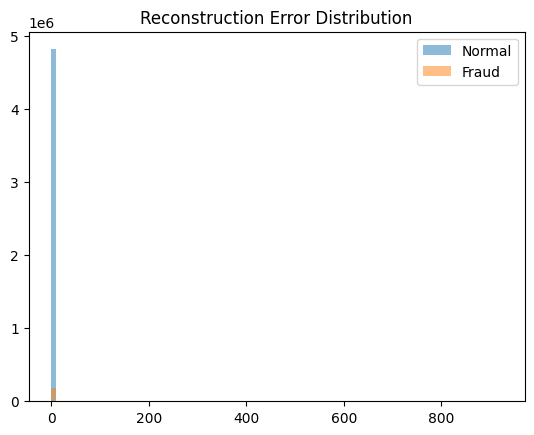

In [16]:
import matplotlib.pyplot as plt

plt.hist(mse_normal, bins=100, alpha=0.5, label="Normal")
plt.hist(mse_fraud, bins=100, alpha=0.5, label="Fraud")
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()

In [17]:
from sklearn.metrics import roc_auc_score

y_true = np.concatenate([
    np.zeros_like(mse_normal),
    np.ones_like(mse_fraud)
])

scores = np.concatenate([mse_normal, mse_fraud])

auc = roc_auc_score(y_true, scores)
print("ROC AUC:", auc)

ROC AUC: 0.4856202168541525
